Відповідно до завдання, потрібно навчити класифікуючу модель, що зможе визначати, чи буде клієнт мати проблеми з оплатою по кредиту, чи не буде.
Розглянемо спершу, які саме дані ми маємо для обробки. Для цього завантажимо train та test таблиці. Аналізувати будемо train таблицю, а зміни в процесі EDA застосовуватимемо до обох.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
train_data = pd.read_csv('data/application_train.csv')
test_data = pd.read_csv('data/application_test.csv')

In [3]:
print(train_data.shape)
train_data.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Як бачимо, об'єм даних досить великий, особливо з точки зору кількості колонок таблиці, виведемо їх назви окремо:

In [4]:
print(list(train_data.columns))

['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELE

- Оскільки в датасеті 122 колонки, описи який є в окремому файлі, розглядати детально кожну з них окремо тут не будемо, виділимо лише головні результати спостережень.
- SK_ID_CURR - ID кредиту, це значення повинне бути унікальним, якщо ж за цим значенням будуть знайдені дублі, їх доцільно буде видалити
- TARGET - цільове значення, за яким ми й будемо проводити класифікацію, 1 позначає наявність проблем з оплатою, 0 - їх відсутність
- Далі маємо велику кількість колонок, що відповідають незалежним змінним. Серед них є як ті, що більш очевидно впливають на TARGET, як от різноманітні дані про майно, фінансовий стан, сімейний статус, вік тощо, так і менш очевидні, проте оскільки вони є, одразу відкидати їх не будемо. Суть деяких колонок є недостатньо зрозумілою, навіть після прочитання їх опису, наприклад FLAG_DOCUMENT_2 до _21, які є булевими значеннями і вказують чи надав клієнт якийсь документ, проте крім номеру цих документів більше ніякої інформації. Також не зовсім зрозумілим є зміст колонок EXT_SOURCE_1 до _3, що позначають оцінку чогось, отриману з зовнішніх джерел у нормалізованому вигляді. До інших колонок щодо їх вмісту питань загалом не виникає.
Значення колонок з EXT_SOURCE_1 до EMERGENCYSTATE_MODE вже нормалізовані (згідно їх опису), що спрощує нам підготовку даних.

Спершу обробимо випадки з відсутніми даними

In [5]:
print(train_data.isnull().sum().to_string(max_rows=None))

SK_ID_CURR                           0
TARGET                               0
NAME_CONTRACT_TYPE                   0
CODE_GENDER                          0
FLAG_OWN_CAR                         0
FLAG_OWN_REALTY                      0
CNT_CHILDREN                         0
AMT_INCOME_TOTAL                     0
AMT_CREDIT                           0
AMT_ANNUITY                         12
AMT_GOODS_PRICE                    278
NAME_TYPE_SUITE                   1292
NAME_INCOME_TYPE                     0
NAME_EDUCATION_TYPE                  0
NAME_FAMILY_STATUS                   0
NAME_HOUSING_TYPE                    0
REGION_POPULATION_RELATIVE           0
DAYS_BIRTH                           0
DAYS_EMPLOYED                        0
DAYS_REGISTRATION                    0
DAYS_ID_PUBLISH                      0
OWN_CAR_AGE                     202929
FLAG_MOBIL                           0
FLAG_EMP_PHONE                       0
FLAG_WORK_PHONE                      0
FLAG_CONT_MOBILE         

Бачимо велику кількість атрибутів, по яких є пропущені значення, розглядатимемо їх групами:
- AMT_ANNUITY, AMT_GOODS_PRICE це неперервні числові атрибути і пропущених значень в них небагато, порівняно з загальним обсягом даних, тому їх можна буде заповнити середнім значенням по відповідному атрибуту

In [6]:
AMT_ANNUITY_mean = train_data['AMT_ANNUITY'].mean()
train_data['AMT_ANNUITY'] = train_data['AMT_ANNUITY'].fillna(AMT_ANNUITY_mean)
test_data['AMT_ANNUITY'] = test_data['AMT_ANNUITY'].fillna(AMT_ANNUITY_mean)
AMT_GOODS_PRICE_mean = train_data['AMT_GOODS_PRICE'].mean()
train_data['AMT_GOODS_PRICE'] = train_data['AMT_GOODS_PRICE'].fillna(AMT_GOODS_PRICE_mean)
test_data['AMT_GOODS_PRICE'] = test_data['AMT_GOODS_PRICE'].fillna(AMT_GOODS_PRICE_mean)

- NAME_TYPE_SUITE це категоріальна змінна, її пропуски можна заповнити модою

In [7]:
NAME_TYPE_SUITE_mode = train_data['NAME_TYPE_SUITE'].mode()[0]
train_data['NAME_TYPE_SUITE'] = train_data['NAME_TYPE_SUITE'].fillna(NAME_TYPE_SUITE_mode)
test_data['NAME_TYPE_SUITE'] = test_data['NAME_TYPE_SUITE'].fillna(NAME_TYPE_SUITE_mode)

- OWN_CAR_AGE, містить значну кількість пропущених значень (більше половини з усіх). Цей атрибут позначає вік машини, якою володіє клієнт, тому можемо зробити висновок, що пропущені значення відповідають випадку, коли клієнт не має авто. Припущення підтверджується тим, що в таблиці є ще одна колонка FLAG_OWN_CAR, негативні значення в якій відповідають пропускам у цій колонці, отже створювати нову колонку щодо наявності авто у клієнта не потрібно, просто заповнимо пропуски медіаною

In [8]:
OWN_CAR_AGE_median = train_data['OWN_CAR_AGE'].median()
train_data['OWN_CAR_AGE'] = train_data['OWN_CAR_AGE'].fillna(OWN_CAR_AGE_median)
test_data['OWN_CAR_AGE'] = test_data['OWN_CAR_AGE'].fillna(OWN_CAR_AGE_median)

- OCCUPATION_TYPE, ще один атрибут зі значними пропусками. Позначає тип професії клієнта, пропуски імовірно відповідають тому, що клієнт непрацевлаштований, в будь якому випадку, оскільки ця змінна категоріальна, всі пропуски позначимо як окрему категорію

In [9]:
train_data['OCCUPATION_TYPE'] = train_data['OCCUPATION_TYPE'].fillna('NA')
test_data['OCCUPATION_TYPE'] = test_data['OCCUPATION_TYPE'].fillna('NA')

- CNT_FAM_MEMBERS, DAYS_LAST_PHONE_CHANGE містять одиничні пропуски, тому зважаючи на загальну кількість даних, можемо просто видалити відповідні рядки, або ж заповнити середнім

In [10]:
CNT_FAM_MEMBERS_mean = train_data['CNT_FAM_MEMBERS'].mean()
train_data['CNT_FAM_MEMBERS'] = train_data['CNT_FAM_MEMBERS'].fillna(CNT_FAM_MEMBERS_mean)
test_data['CNT_FAM_MEMBERS'] = test_data['CNT_FAM_MEMBERS'].fillna(CNT_FAM_MEMBERS_mean)
DAYS_LAST_PHONE_CHANGE_mean = train_data['DAYS_LAST_PHONE_CHANGE'].mean()
train_data['DAYS_LAST_PHONE_CHANGE'] = train_data['DAYS_LAST_PHONE_CHANGE'].fillna(DAYS_LAST_PHONE_CHANGE_mean)
test_data['DAYS_LAST_PHONE_CHANGE'] = test_data['DAYS_LAST_PHONE_CHANGE'].fillna(DAYS_LAST_PHONE_CHANGE_mean)

- EXT_SOURCE_1, 2, 3 містять різну кількість пропусків, але для 1 і 3 ця кількість є значною. Що саме позначають ці атрибути, як було згадано вище, не зовсім зрозуміло, тому визначати як саме обробити їх пропуски на цьому етапі буде важко. Як варіант, можна заповнити пропуски медіаною, або видалити колонки EXT_SOURCE_1 і EXT_SOURCE_3, дозаповнивши лише EXT_SOURCE_2 де кількість пропусків не така значна

- колонки від APARTMENTS_AVG до EMERGENCYSTATE_MODE містять інформацію про житло клієнта, та мають значну кількість пропусків (близько половини з усіх значень для кожної з колонок). Якщо загалом проглянути записи в цих колонках, можна помітити що рядки або не мають записів в жодній з колонок цієї групи, або мають записи у більшості з них, але все ще з певними пропусками. Якби інформація тут була про житло, яким клієнт саме володіє, а не орендує, можна було б припустити що там де записи відсутні для всіх колонок, клієнт не має у власності нерухомість, проте судячи з опису цих колонок, мова йде саме про місце де клієнт проживає, отже пропуски пов'язані з чимось іншим, наприклад що клієнт не надав інформацію про своє житло. Зважаючи на дуже значну кількість пропусків в атрибутах цієї групи, їхне заповнення середніми значеннями для неперервних, чи модою для категоріальних змінних очевидно сильно вплине на інформативність цих колонок, тому можливим рішенням є ігнорувати цю групу колонок при навчанні , замінивши їх одним атрибутом щодо надання клієнтом інформації про своє житло (0 - значення у всіх цих колонках відсутні, інакше 1)

In [11]:
#перевірятимемо лише колонку з найменшою кількістю пропусків, це забезпечить виконання поставленої умови
train_data['APARTMENTS_INFO_EXIST'] = train_data['YEARS_BEGINEXPLUATATION_AVG'].apply(lambda x: 0 if pd.isnull(x) else 1)
test_data['APARTMENTS_INFO_EXIST'] = test_data['YEARS_BEGINEXPLUATATION_AVG'].apply(lambda x: 0 if pd.isnull(x) else 1)
col_to_drop = ['APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 
               'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 
               'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 
               'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 
               'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 
               'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 
               'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 
               'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'TOTALAREA_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']
train_data.drop(columns=col_to_drop, inplace=True)
test_data.drop(columns=col_to_drop, inplace=True)

- OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, OBS_60_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE, неперервні змінні з порівняно невеликою кількістю пропусків, заповнимо їх модою

In [12]:
OBS_30_CNT_SOCIAL_CIRCLE_mode = train_data['OBS_30_CNT_SOCIAL_CIRCLE'].mode()[0]
OBS_60_CNT_SOCIAL_CIRCLE_mode = train_data['OBS_60_CNT_SOCIAL_CIRCLE'].mode()[0]
DEF_30_CNT_SOCIAL_CIRCLE_mode = train_data['DEF_30_CNT_SOCIAL_CIRCLE'].mode()[0]
DEF_60_CNT_SOCIAL_CIRCLE_mode = train_data['DEF_60_CNT_SOCIAL_CIRCLE'].mode()[0]
train_data['OBS_30_CNT_SOCIAL_CIRCLE'] = train_data['OBS_30_CNT_SOCIAL_CIRCLE'].fillna(OBS_30_CNT_SOCIAL_CIRCLE_mode)
train_data['DEF_30_CNT_SOCIAL_CIRCLE'] = train_data['DEF_30_CNT_SOCIAL_CIRCLE'].fillna(DEF_30_CNT_SOCIAL_CIRCLE_mode)
train_data['OBS_60_CNT_SOCIAL_CIRCLE'] = train_data['OBS_60_CNT_SOCIAL_CIRCLE'].fillna(OBS_60_CNT_SOCIAL_CIRCLE_mode)
train_data['DEF_60_CNT_SOCIAL_CIRCLE'] = train_data['DEF_60_CNT_SOCIAL_CIRCLE'].fillna(DEF_60_CNT_SOCIAL_CIRCLE_mode)
test_data['OBS_30_CNT_SOCIAL_CIRCLE'] = test_data['OBS_30_CNT_SOCIAL_CIRCLE'].fillna(OBS_30_CNT_SOCIAL_CIRCLE_mode)
test_data['DEF_30_CNT_SOCIAL_CIRCLE'] = test_data['DEF_30_CNT_SOCIAL_CIRCLE'].fillna(DEF_30_CNT_SOCIAL_CIRCLE_mode)
test_data['OBS_60_CNT_SOCIAL_CIRCLE'] = test_data['OBS_60_CNT_SOCIAL_CIRCLE'].fillna(OBS_60_CNT_SOCIAL_CIRCLE_mode)
test_data['DEF_60_CNT_SOCIAL_CIRCLE'] = test_data['DEF_60_CNT_SOCIAL_CIRCLE'].fillna(DEF_60_CNT_SOCIAL_CIRCLE_mode)

- AMT_REQ_CREDIT_BUREAU_... містять однакову кількість пропусків кожен, тобто у рядку або всі ці атрибути заповнені, або всі незаповнені. Ці колонки містять інформацію про кількість запитів щодо клієнта за певні проміжки часу, тобто скоріш за все є якоюсь технічною інформацією, що заповнюється не клієнтом а отримується зі сторонніх джерел. Тому навряд буде доцільно створювати додатковий булевий атрибут щодо наявності даних в цій групі колонок, але й видаляти записи що містять тут пропуски теж не будемо, адже їх є досить багато, тому просто заповнимо пропуски відповідними модами.

In [13]:
train_data['AMT_REQ_CREDIT_BUREAU_HOUR'] = train_data['AMT_REQ_CREDIT_BUREAU_HOUR'].fillna(train_data['AMT_REQ_CREDIT_BUREAU_HOUR'].mode()[0])
train_data['AMT_REQ_CREDIT_BUREAU_DAY'] = train_data['AMT_REQ_CREDIT_BUREAU_DAY'].fillna(train_data['AMT_REQ_CREDIT_BUREAU_DAY'].mode()[0])
train_data['AMT_REQ_CREDIT_BUREAU_WEEK'] = train_data['AMT_REQ_CREDIT_BUREAU_WEEK'].fillna(train_data['AMT_REQ_CREDIT_BUREAU_WEEK'].mode()[0])
train_data['AMT_REQ_CREDIT_BUREAU_MON'] = train_data['AMT_REQ_CREDIT_BUREAU_MON'].fillna(train_data['AMT_REQ_CREDIT_BUREAU_MON'].mode()[0])
train_data['AMT_REQ_CREDIT_BUREAU_QRT'] = train_data['AMT_REQ_CREDIT_BUREAU_QRT'].fillna(train_data['AMT_REQ_CREDIT_BUREAU_QRT'].mode()[0])
train_data['AMT_REQ_CREDIT_BUREAU_YEAR'] = train_data['AMT_REQ_CREDIT_BUREAU_YEAR'].fillna(train_data['AMT_REQ_CREDIT_BUREAU_YEAR'].mode()[0])
test_data['AMT_REQ_CREDIT_BUREAU_HOUR'] = test_data['AMT_REQ_CREDIT_BUREAU_HOUR'].fillna(train_data['AMT_REQ_CREDIT_BUREAU_HOUR'].mode()[0])
test_data['AMT_REQ_CREDIT_BUREAU_DAY'] = test_data['AMT_REQ_CREDIT_BUREAU_DAY'].fillna(train_data['AMT_REQ_CREDIT_BUREAU_DAY'].mode()[0])
test_data['AMT_REQ_CREDIT_BUREAU_WEEK'] = test_data['AMT_REQ_CREDIT_BUREAU_WEEK'].fillna(train_data['AMT_REQ_CREDIT_BUREAU_WEEK'].mode()[0])
test_data['AMT_REQ_CREDIT_BUREAU_MON'] = test_data['AMT_REQ_CREDIT_BUREAU_MON'].fillna(train_data['AMT_REQ_CREDIT_BUREAU_MON'].mode()[0])
test_data['AMT_REQ_CREDIT_BUREAU_QRT'] = test_data['AMT_REQ_CREDIT_BUREAU_QRT'].fillna(train_data['AMT_REQ_CREDIT_BUREAU_QRT'].mode()[0])
test_data['AMT_REQ_CREDIT_BUREAU_YEAR'] = test_data['AMT_REQ_CREDIT_BUREAU_YEAR'].fillna(train_data['AMT_REQ_CREDIT_BUREAU_YEAR'].mode()[0])

Тепер повторно перевіримо кількість пропусків по колонках

In [14]:
print(train_data.isnull().sum().to_string(max_rows=None))

SK_ID_CURR                          0
TARGET                              0
NAME_CONTRACT_TYPE                  0
CODE_GENDER                         0
FLAG_OWN_CAR                        0
FLAG_OWN_REALTY                     0
CNT_CHILDREN                        0
AMT_INCOME_TOTAL                    0
AMT_CREDIT                          0
AMT_ANNUITY                         0
AMT_GOODS_PRICE                     0
NAME_TYPE_SUITE                     0
NAME_INCOME_TYPE                    0
NAME_EDUCATION_TYPE                 0
NAME_FAMILY_STATUS                  0
NAME_HOUSING_TYPE                   0
REGION_POPULATION_RELATIVE          0
DAYS_BIRTH                          0
DAYS_EMPLOYED                       0
DAYS_REGISTRATION                   0
DAYS_ID_PUBLISH                     0
OWN_CAR_AGE                         0
FLAG_MOBIL                          0
FLAG_EMP_PHONE                      0
FLAG_WORK_PHONE                     0
FLAG_CONT_MOBILE                    0
FLAG_PHONE  

А також для тестового набору

In [15]:
print(test_data.isnull().sum().to_string(max_rows=None))

SK_ID_CURR                         0
NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
CNT_CHILDREN                       0
AMT_INCOME_TOTAL                   0
AMT_CREDIT                         0
AMT_ANNUITY                        0
AMT_GOODS_PRICE                    0
NAME_TYPE_SUITE                    0
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
REGION_POPULATION_RELATIVE         0
DAYS_BIRTH                         0
DAYS_EMPLOYED                      0
DAYS_REGISTRATION                  0
DAYS_ID_PUBLISH                    0
OWN_CAR_AGE                        0
FLAG_MOBIL                         0
FLAG_EMP_PHONE                     0
FLAG_WORK_PHONE                    0
FLAG_CONT_MOBILE                   0
FLAG_PHONE                         0
FLAG_EMAIL                         0
O

Пропуски залишились лише для EXT_SOURCE_1, 2 і 3 які далі перевіримо на кореляцію, і тоді визначимо що з ними робити.

Всі категоріальні колонки, що використовуватимуться для навчання тепер не містять пропусків, тому можемо їх явно позначити як категоріальні

In [16]:
categorical_features = ['APARTMENTS_INFO_EXIST', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 
                        'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 
                        'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'REGION_RATING_CLIENT', 
                        'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 
                        'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 
                        'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 
                        'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 
                        'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 
                        'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']
for feature in categorical_features:
    train_data[feature] = train_data[feature].astype('category')

Також позначимо категоріальні колонки у тестовому наборі, але враховуючи те, що він не містить колонки TARGET

In [17]:
for feature in categorical_features:
    if feature != 'TARGET':
        test_data[feature] = test_data[feature].astype('category')

Тепер переглянемо типи даних наших атрибутів

In [18]:
print(train_data.dtypes.to_string(max_rows=None))

SK_ID_CURR                        int64
TARGET                         category
NAME_CONTRACT_TYPE             category
CODE_GENDER                    category
FLAG_OWN_CAR                   category
FLAG_OWN_REALTY                category
CNT_CHILDREN                      int64
AMT_INCOME_TOTAL                float64
AMT_CREDIT                      float64
AMT_ANNUITY                     float64
AMT_GOODS_PRICE                 float64
NAME_TYPE_SUITE                category
NAME_INCOME_TYPE               category
NAME_EDUCATION_TYPE            category
NAME_FAMILY_STATUS             category
NAME_HOUSING_TYPE              category
REGION_POPULATION_RELATIVE      float64
DAYS_BIRTH                        int64
DAYS_EMPLOYED                     int64
DAYS_REGISTRATION               float64
DAYS_ID_PUBLISH                   int64
OWN_CAR_AGE                     float64
FLAG_MOBIL                     category
FLAG_EMP_PHONE                 category
FLAG_WORK_PHONE                category


Також перевіримо на наявність дублікатів

In [19]:
train_data[train_data.duplicated()]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_INFO_EXIST


Розглянемо розподіл наших значень за змінною TARGET

In [20]:
train_data['TARGET'].describe(include='all')

count     307511
unique         2
top            0
freq      282686
Name: TARGET, dtype: int64

Вона приймає лише два значення, 0 або 1, але бачимо явний дизбаланс у сторону значння 0 (таких записів більше 90%), що відповідає випадку коли клієнт не мав проблем з виплатами по кредиту.
Отже наш набір даних незбалансований. Поки що не будемо намагатись його збалансувати, але якщо спроба навчити модель на поточних даних покаже незадовільний результат, можна буде спробувати додати до неї синтетичні записи.

<Axes: xlabel='count', ylabel='TARGET'>

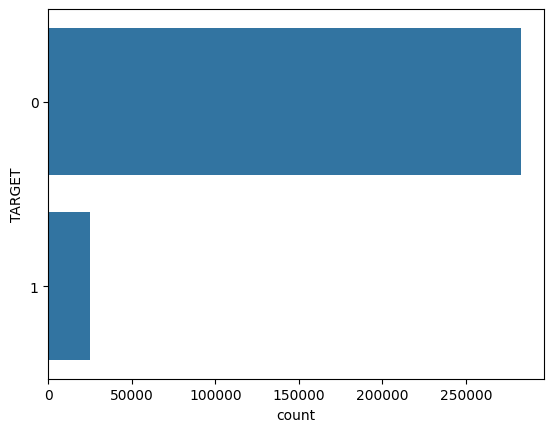

In [21]:
sns.countplot(train_data['TARGET'])

Крім того для наочності можемо розглянути графіки розподілу і для неперервних змінних

array([[<Axes: title={'center': 'SK_ID_CURR'}>,
        <Axes: title={'center': 'CNT_CHILDREN'}>,
        <Axes: title={'center': 'AMT_INCOME_TOTAL'}>,
        <Axes: title={'center': 'AMT_CREDIT'}>,
        <Axes: title={'center': 'AMT_ANNUITY'}>],
       [<Axes: title={'center': 'AMT_GOODS_PRICE'}>,
        <Axes: title={'center': 'REGION_POPULATION_RELATIVE'}>,
        <Axes: title={'center': 'DAYS_BIRTH'}>,
        <Axes: title={'center': 'DAYS_EMPLOYED'}>,
        <Axes: title={'center': 'DAYS_REGISTRATION'}>],
       [<Axes: title={'center': 'DAYS_ID_PUBLISH'}>,
        <Axes: title={'center': 'OWN_CAR_AGE'}>,
        <Axes: title={'center': 'CNT_FAM_MEMBERS'}>,
        <Axes: title={'center': 'EXT_SOURCE_1'}>,
        <Axes: title={'center': 'EXT_SOURCE_2'}>],
       [<Axes: title={'center': 'EXT_SOURCE_3'}>,
        <Axes: title={'center': 'OBS_30_CNT_SOCIAL_CIRCLE'}>,
        <Axes: title={'center': 'DEF_30_CNT_SOCIAL_CIRCLE'}>,
        <Axes: title={'center': 'OBS_60_CNT_SOCI

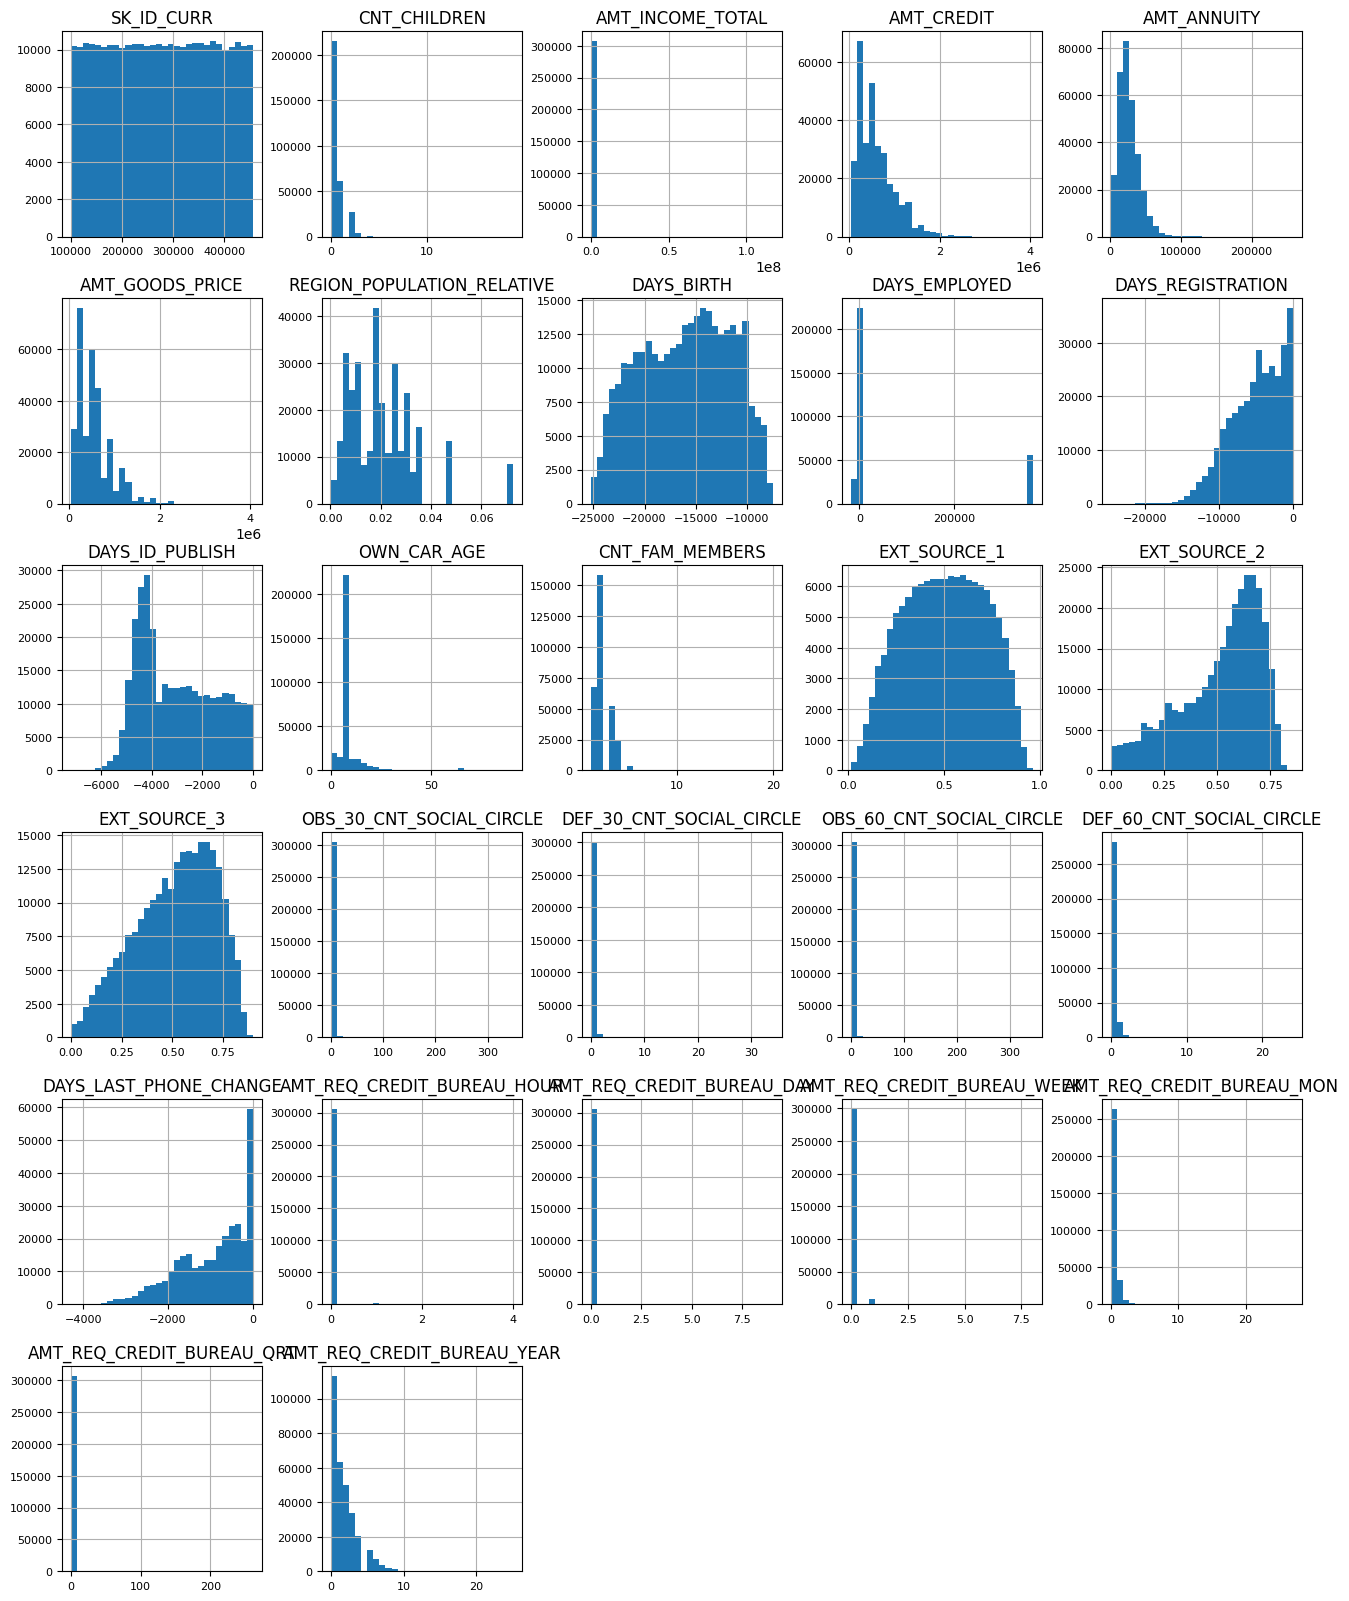

In [22]:
numerical_features = train_data.select_dtypes(include = ['float64', 'int64']).columns
train_data[numerical_features].hist(figsize=(16, 20), bins=30, xlabelsize=8, ylabelsize=8)

- Для деяких змінних бачимо довгі хвости на графіках ('CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_QRT').
- Деякі з аномальних значень можна буде відкинути, адже вони можуть бути помилковими, а якщо навіть ні, то все рівно можуть заважати при навчанні.
- Також бачимо різкий пік на графіку OWN_CAR_AGE, викликаний заповненням пропусків в цій колонці середнім значенням
- Ще одна аномалія є на графіку DAYS_EMPLOYED, де значна кількість записів набуває дуже високих значень, які не мають змісту, адже колонка показує кількість днів, яку клієнт працює на поточній роботі. Можна зробити припущення що всі ці записи відповідають якомусь максимальному значенню.

In [23]:
train_data['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [24]:
(train_data['DAYS_EMPLOYED'] == 365243).sum()

55374

Отже напевне маємо пошкоджені записи. Через значну їх кількість видаляти відповідні рядки не будемо, можемо припустити що ці записи відповідають значенню 0 тому перезапишемо їх і поглянемо на розподіл ще раз

<Axes: >

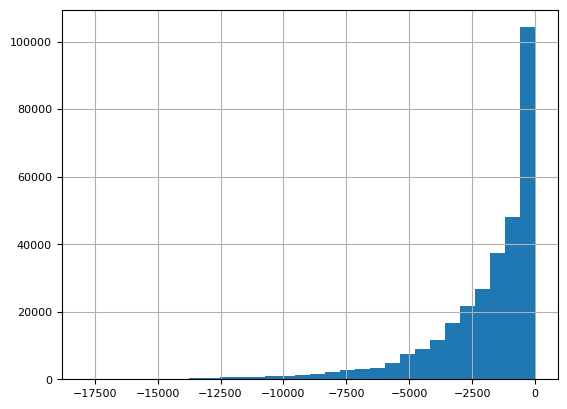

In [25]:
train_data['DAYS_EMPLOYED'] = train_data['DAYS_EMPLOYED'].replace(365243, 0)
test_data['DAYS_EMPLOYED'] = test_data['DAYS_EMPLOYED'].replace(365243, 0)
train_data['DAYS_EMPLOYED'].hist(bins=30, xlabelsize=8, ylabelsize=8)

Тепер дані виглядають більш органічно, вважатимемо що виправлення було коректним

Розглянемо тепер аномальні значення по змінним

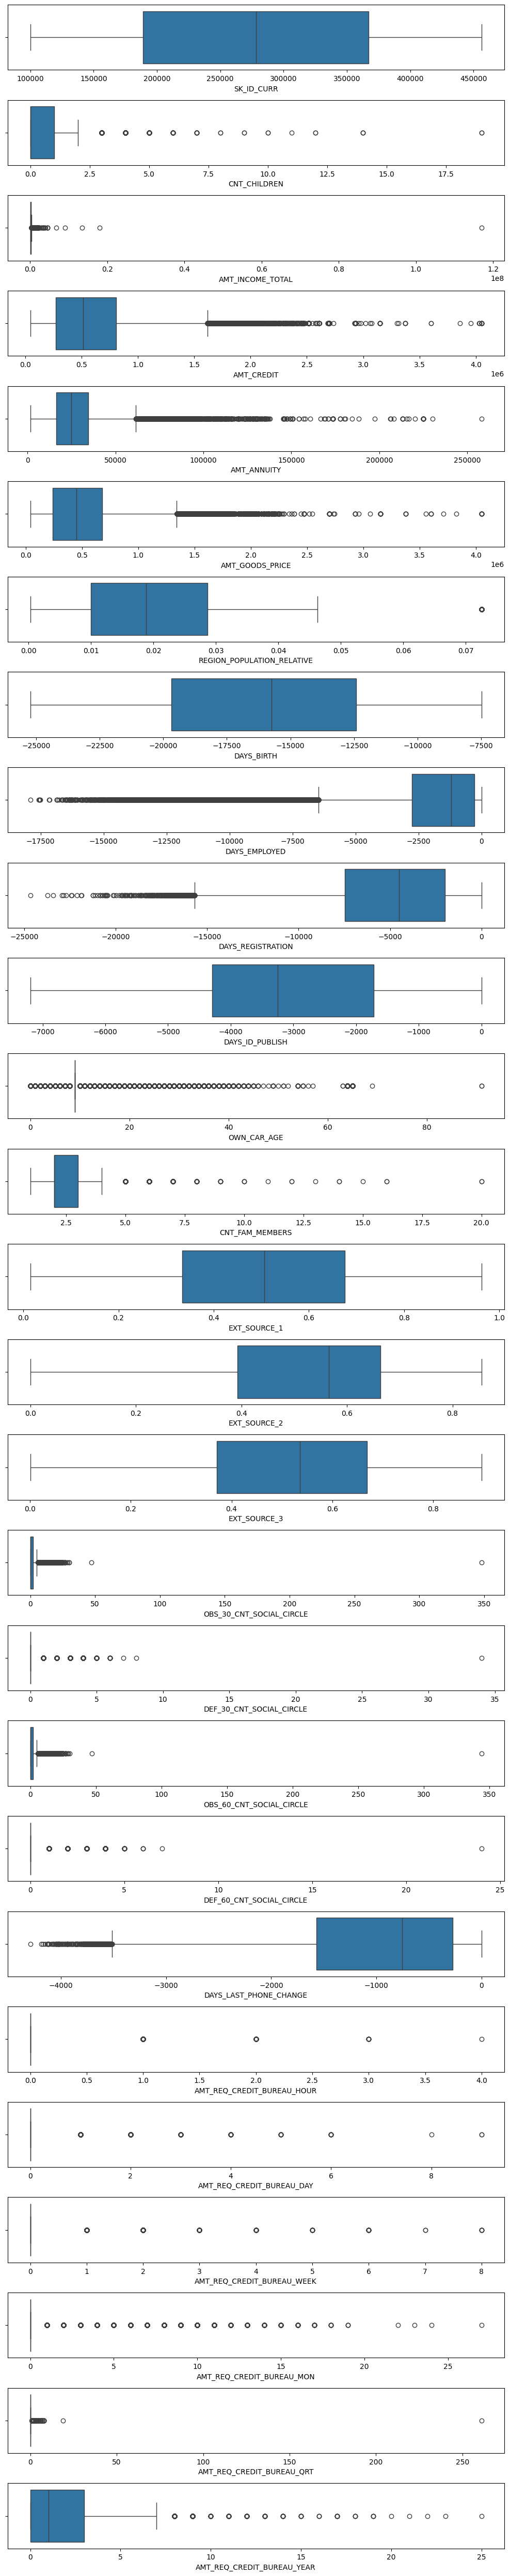

In [26]:
fig, axes = plt.subplots(nrows=len(numerical_features), ncols=1)
fig.set_size_inches(10, 50)
for i, col in enumerate(numerical_features):
    sns.boxplot(train_data[col], orient='h', ax=axes[i])
plt.tight_layout()
plt.show()

Отже які висновки можна зробити з цих графіків:
- CNT_CHILDREN, значення що формують хвіст хоч і теоретично можуть бути реальними, проте справді є скоріше унікальними випадками, тому доречно буде видалити записи зі значенням > 5
- AMT_INCOME_TOTAL, скоротимо хвіст, видаливши записи зі значенням > 0.6*1e8
- CNT_FAM_MEMBERS, скорочуємо аналогічно до CNT_CHILDREN
- OBS_30_CNT_SOCIAL_CIRCLE та OBS_60_CNT_SOCIAL_CIRCLE, скоротимо записи після 100
- DEF_30_CNT_SOCIAL_CIRCLE та DEF_60_CNT_SOCIAL_CIRCLE, скоротимо записи після 10

In [27]:
train_data.drop(train_data[train_data['CNT_CHILDREN'] > 5].index, inplace=True)
train_data.drop(train_data[train_data['AMT_INCOME_TOTAL'] > 0.5*1e8].index, inplace=True)
train_data.drop(train_data[train_data['CNT_FAM_MEMBERS'] > 5].index, inplace=True)
train_data.drop(train_data[train_data['OBS_30_CNT_SOCIAL_CIRCLE'] > 100].index, inplace=True)
train_data.drop(train_data[train_data['DEF_30_CNT_SOCIAL_CIRCLE'] > 10].index, inplace=True)
train_data.drop(train_data[train_data['OBS_60_CNT_SOCIAL_CIRCLE'] > 100].index, inplace=True)
train_data.drop(train_data[train_data['DEF_60_CNT_SOCIAL_CIRCLE'] > 10].index, inplace=True)

In [28]:
train_data.count()

SK_ID_CURR                    306980
TARGET                        306980
NAME_CONTRACT_TYPE            306980
CODE_GENDER                   306980
FLAG_OWN_CAR                  306980
                               ...  
AMT_REQ_CREDIT_BUREAU_WEEK    306980
AMT_REQ_CREDIT_BUREAU_MON     306980
AMT_REQ_CREDIT_BUREAU_QRT     306980
AMT_REQ_CREDIT_BUREAU_YEAR    306980
APARTMENTS_INFO_EXIST         306980
Length: 76, dtype: int64

Побудуємо кореляційну матрицю

<Axes: >

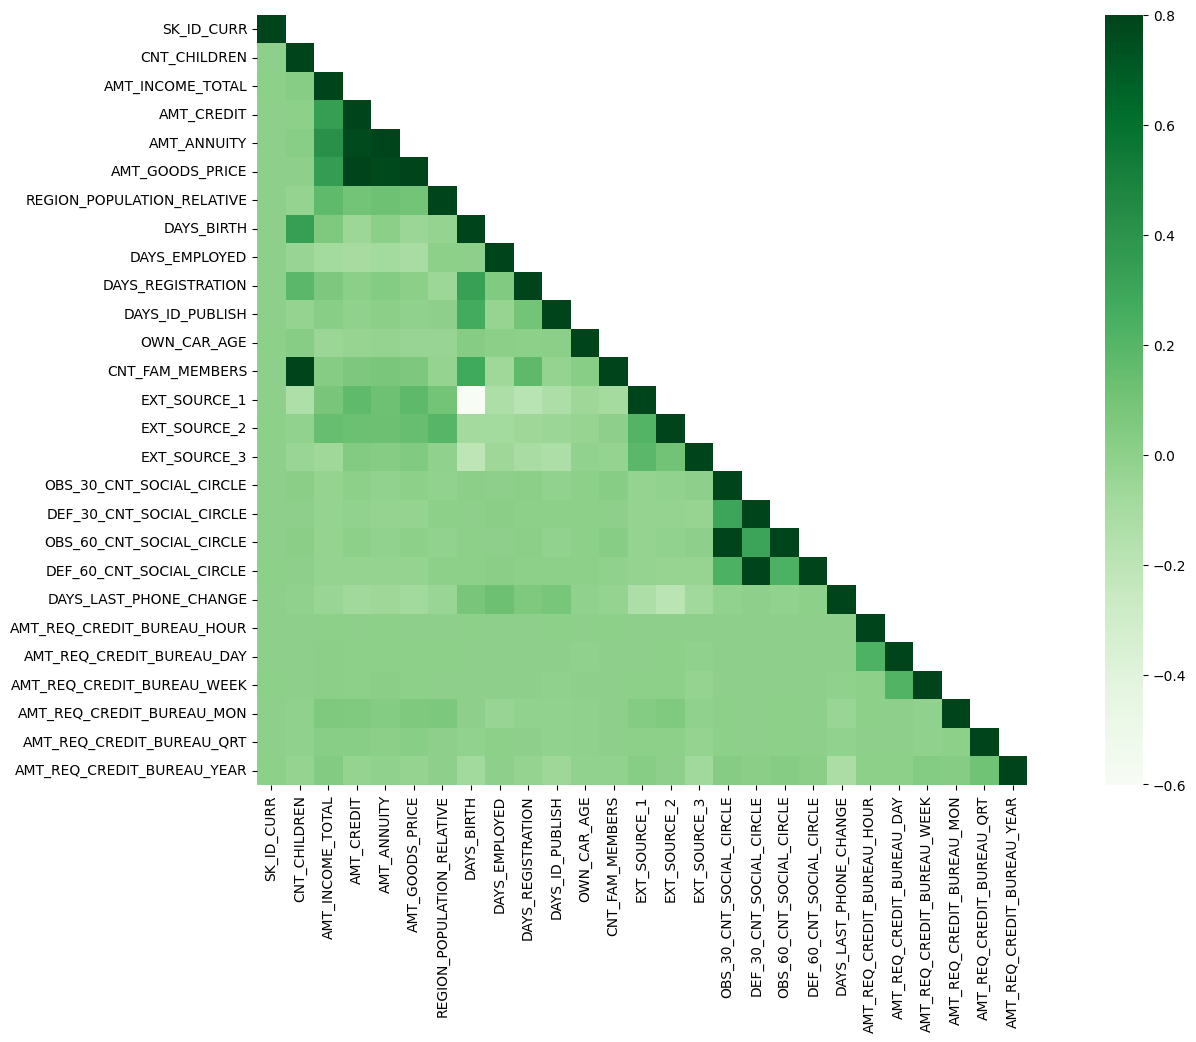

In [29]:
corrMatt = train_data[numerical_features].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sns.heatmap(corrMatt, cmap="Greens", mask=mask, vmax=.8, square=True)

Бачимо кілька випадків сильно корельованих колонок:
- CNT_FAM_MEMBERS та CNT_CHILDREN, що цілком логічно, адже загальна кількість членів родини визначається в тому числі й кількістю дітей
- AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, кореляція між ними теж логічна, адже всі вони так чи інакше першочергово залежать від одного й того ж фактору
- OBS_30_CNT_SOCIAL_CIRCLE з OBS_60_CNT_SOCIAL_CIRCLE та DEF_30_CNT_SOCIAL_CIRCLE з DEF_60_CNT_SOCIAL_CIRCLE, ці пари характеристик відображають по суті одне й те ж, але за різні проміжки часу (30 днів та 60), але вочевидь покриття в 30 днів було достатньо, тому й отримали сильну кореляцію

При навчанні буде недоцільно використовувати кілька сильно корельованих змінних, тому доцільно буде деякі з них прибрати, наприклад CNT_FAM_MEMBERS, OBS_60_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE, AMT_ANNUITY (AMT_GOODS_PRICE залишимо, він корелює з AMT_CREDIT трохи менше)

In [30]:
train_data.drop(columns=['CNT_FAM_MEMBERS', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_ANNUITY'], inplace=True)
test_data.drop(columns=['CNT_FAM_MEMBERS', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_ANNUITY'], inplace=True)

Також невирішеним залишається проблема пропусків у колонках EXT_SOURCE_1, 2, 3.
Як ми тепер бачимо, вони не корелюють ні з якою іншою колонкою, ні між собою. Отже потрібно або видаляти їх, або дозаповнювати. Опис даних що містяться в цих колонках не дозволяє зробити висновок щодо їх потенційної корисності, тому вважатимемо що вони містять важливі дані і просто видаляти ці колонки буде недоречно. Тоді будемо їх дозаповнювати, але використати для цього значення медіан чи середнього теж може бути неефективним.
Спробуємо об'єднати ці три колонки в одну, бо EXT_SOURCE_2 містить відносну невелику кількість пропусків і можна брати середнє з 1, 2 і 3, а для записів, де відсутні значення у всіх трьох колонках, вже заповнимо середнім

In [31]:
train_data['EXT_SOURCE'] = train_data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1, skipna=True)
test_data['EXT_SOURCE'] = test_data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1, skipna=True)

print(train_data['EXT_SOURCE'].isnull().sum())
print(test_data['EXT_SOURCE'].isnull().sum())

172
7


In [32]:
train_data['EXT_SOURCE'] = train_data['EXT_SOURCE'].fillna(train_data['EXT_SOURCE'].mean())
test_data['EXT_SOURCE'] = test_data['EXT_SOURCE'].fillna(train_data['EXT_SOURCE'].mean())
print(train_data['EXT_SOURCE'].isnull().sum())
print(test_data['EXT_SOURCE'].isnull().sum())

0
0


In [33]:
train_data.drop(columns=['SK_ID_CURR', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], inplace=True)
test_data.drop(columns=['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], inplace=True)

Дані підготовлені, перейдемо до побудови класифікатора

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score

Спершу виконаємо фінальну обробку даних. Розділяємо таблиці

In [35]:
X_test = test_data.drop(columns=['SK_ID_CURR'])
X = train_data.drop(columns=['TARGET'])
y = train_data['TARGET']

Відділяємо частину навчальних даних для валідації

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Перетворимо колонки які мають категоріальний тип у розріджену матрицю за допомогою One-hot encoding. Спершу потрібно отримати всі можливі варіації категорій з усіх трьох таблиць, адже якщо ми виконаємо fit_transform для таблиці X_train, а для інших намагатимемось виконати transform, отримаємо помилку щодо невідомих категорій в колонках

In [37]:
encoder = OneHotEncoder()
all_categorical_values = pd.concat([X_train.select_dtypes(include=['object']), X_val.select_dtypes(include=['object']), X_test.select_dtypes(include=['object'])])
encoder.fit(all_categorical_values)
X_train_encoded = encoder.transform(X_train.select_dtypes(include = ['object']))
X_val_encoded = encoder.transform(X_val.select_dtypes(include = ['object']))
X_test_encoded = encoder.transform(X_test.select_dtypes(include = ['object']))

Стандартизуємо числові колонки

In [38]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.select_dtypes(include = ['float64', 'int64']))
X_val_scaled = scaler.transform(X_val.select_dtypes(include = ['float64', 'int64']))
X_test_scaled = scaler.transform(X_test.select_dtypes(include = ['float64', 'int64']))

Оскільки після кодування та стандартизації ми отримали окрему розріджені матриці і окремо таблиці з числовими колонками, робимо з них знову одну таблицю

In [39]:
X_train_combined = np.concatenate((X_train_encoded.toarray(), X_train_scaled), axis=1)
X_val_combined = np.concatenate((X_val_encoded.toarray(), X_val_scaled), axis=1)
X_test_combined = np.concatenate((X_test_encoded.toarray(), X_test_scaled), axis=1)

Використовуємо інструмент LogisticRegression для навчання моделі

In [40]:
model = LogisticRegression()
model.fit(X_train_combined, y_train)

LogisticRegression()

Оцінимо метрику побудованої моделі за критерієм ROC-AUC

In [41]:
y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_proba)
print("ROC-AUC:", roc_auc)

ROC-AUC: 0.727725612394811


Значення 0.727 відповідає цілком задовільному результату, але як пам'ятаємо наші дані сильно незбалансовані по цільовому параметру, тому спробуємо побудувати модель знову, але явно вказавши на необхідність їх балансування

In [42]:
model1 = LogisticRegression(class_weight='balanced')
model1.fit(X_train_combined, y_train)

LogisticRegression(class_weight='balanced')

In [43]:
y_pred_proba = model1.predict_proba(X_val_scaled)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_proba)
print("ROC-AUC:", roc_auc)

ROC-AUC: 0.7278321092078062


Значного покращення якості моделі це не принесло, отже цей метод побудови моделі є стійким до незбалансованих даних

Використаємо побудовану модель для прогнозування цільового класу на тестових даних

In [44]:
test_pred = pd.DataFrame()
test_pred['SK_ID_CURR'] = test_data['SK_ID_CURR']
test_pred['TARGET'] = model.predict(X_test_scaled)
test_pred.head()

,SK_ID_CURR,TARGET
0,100001,0
1,100005,0
2,100013,0
3,100028,0
4,100038,0


Зберігаємо таблицю у вигляді файлу, та відправляємо на перевірку

In [45]:
test_pred.to_csv('test_prediction.csv', index=False)

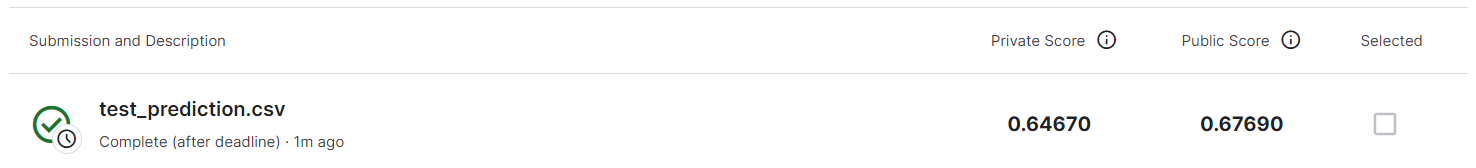